In [1]:
import os
import configparser
import json
import random
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
from utils import create_folder, preprocess_dict_keys, get_image_id, get_month, get_year, get_week_day, part_of_day

In [2]:
cp = configparser.ConfigParser()
cp.read('config.ini')
raw_data_path = cp['DATA_PATH']['raw_data_path']
processed_data_path = cp['DATA_PATH']['processed_data_path']
images_path = cp['DATA_PATH']['images_path']
# Create output folder if it does not exist
create_folder(processed_data_path)

---

# Generate a white list of validated images

In [3]:
# Get black list image_path
lsc2021_removed_list_fp = os.path.join(raw_data_path, 'lsc21-removed-list.txt')
lsc2021_removed_list = [get_image_id(line.rstrip()) for line in open(lsc2021_removed_list_fp, 'r').readlines()]

In [4]:
# Get a list of image ids
image_list_path = os.path.join(raw_data_path, 'raw_image_paths.txt')
white_list_path = os.path.join(processed_data_path, 'white_list_image_ids.txt')
white_list_image_path = os.path.join(processed_data_path, 'white_list_image_paths.txt')

# Create an image_path list file if it does not exist
if not os.path.exists(image_list_path):
    image_path_list = []
    for date in os.listdir(images_path):
        date_path = os.path.join(images_path, date)
        image_paths = sorted([os.path.join(date_path, image_name) for image_name in os.listdir(date_path)])
        image_path_list += image_paths 
    with open(image_list_path, 'w') as f:
        for image_path in image_path_list:
            print(image_path, file = f)

if not os.path.exists(white_list_path):
    # Load the image_path list
    image_path_list = [line.rstrip() for line in open(image_list_path, 'r').readlines()]
    image_id_list = [get_image_id(image_path) for image_path in image_path_list]

    # Generate a white-list image ids
    image_id_white_list = list(filter(lambda image_id: image_id not in lsc2021_removed_list, image_id_list))
    with open(white_list_path, 'w') as f:
        for image_id in image_id_white_list:
            print(image_id, file = f)
    
    # Generate corresponding white-list image paths
    white_list_index = filter(lambda item: item[1] in image_id_white_list, enumerate(image_id_list))
    with open(white_list_image_path, 'w') as f:
        for item in white_list_index:
            index, _ = item
            print(image_path_list[index], file = f)

In [5]:
# Load image id white list and image path white list
image_id_white_list = [line.rstrip() for line in open(white_list_path, 'r').readlines()]
image_path_white_list = [line.rstrip() for line in open(white_list_image_path, 'r').readlines()]

---

# Generate a combined Scaled YOLOv4 Features

In [6]:
yolov4_features_file_path = os.path.join(processed_data_path, 'ScaledYOLOv4_concepts.json')

if not os.path.exists(yolov4_features_file_path):
    # Confidence threshold set in YOLOv4 detect.py file was 0.7
    combined_yolo_features = {}
    for image_path in image_path_white_list:
        date, image_name = image_path.split('/')[-2:]
        image_id = get_image_id(image_name)
        concept_path = os.path.join(raw_data_path, 'ScaledYOLOv4_Features', date, image_id + '.txt')
        combined_yolo_features[image_id] = []
        if os.path.exists(concept_path):
            detected_objects = [line.rstrip() for line in open(concept_path, 'r').readlines()]
            for obj in detected_objects:
                obj_name, *r = obj.split()
                combined_yolo_features[image_id].append(obj_name)
    with open(yolov4_features_file_path, 'w') as f:
        json.dump(combined_yolo_features, f, indent = 4)

---

# Generate a combined Microsoft Tags Features

In [7]:
microsoft_tags_file_path = os.path.join(raw_data_path, 'microsoft_tags.json')
combined_microsoft_tags_path = os.path.join(processed_data_path, 'MicrosoftTags_concepts.json')

if not os.path.exists(combined_microsoft_tags_path):
    MICROSOFT_TAGS_CONFIDENCE_THRESHOLD = 0.7
    combined_microsoft_tags = {}    
    
    # Load raw data
    with open(microsoft_tags_file_path, 'r') as f:
        microsoft_tags = json.load(f)
    
    # Pre-process microsoft tags
    microsoft_tags = preprocess_dict_keys(microsoft_tags)

    for image_path in image_path_white_list:
        image_id = get_image_id(image_path)
        combined_microsoft_tags[image_id] = []
        try:
            for concept_name, conf_score in microsoft_tags[image_id].items():
                if conf_score >= MICROSOFT_TAGS_CONFIDENCE_THRESHOLD:
                    combined_microsoft_tags[image_id].append(concept_name)
        except: continue

    with open(combined_microsoft_tags_path, 'w') as f:
        json.dump(combined_microsoft_tags, f, indent = 4)

---

# Generate a combined OCR Features

In [8]:
ocr_file_path = os.path.join(raw_data_path, 'OCR_LSC.json')
combined_ocr_file_path = os.path.join(processed_data_path, 'OCR_concepts.json')

if not os.path.exists(combined_ocr_file_path):
    combined_ocr = {}
    
    # Load raw data
    with open(ocr_file_path, 'r') as f:
        ocr = json.load(f)
    
    # Pre-process ocr tags
    ocr = preprocess_dict_keys(ocr)
    
    for image_path in image_path_white_list:
        image_id = get_image_id(image_path)
        combined_ocr[image_id] = ''
        try:
            combined_ocr[image_id] = ocr[image_id]
        except: continue
    
    with open(combined_ocr_file_path, 'w') as f:
        json.dump(combined_ocr, f, indent = 4)

---

# Generate a combined Visual Genome Features

In [9]:
from nms import nms

In [10]:
visual_genome_path = os.path.join(raw_data_path, 'visual_genome_res101', 'visual_genome_res101', 'detection')
combined_visual_genome_path = os.path.join(processed_data_path, 'VisualGenomeRes101_concepts.json')

In [11]:
if not os.path.exists(combined_visual_genome_path):
    # Combine raw visual genome concepts & bboxes & scores
    raw_visual_genome = {}
    for image_path in image_path_white_list:
        date, image_name = image_path.split('/')[-2:]
        image_id = get_image_id(image_name)
        concept_path = os.path.join(visual_genome_path, date, image_id + '.json')
        raw_visual_genome[image_id] = []
        if os.path.exists(concept_path):
            detected_concepts = json.load(open(concept_path, 'r'))
            for concept in detected_concepts:
                visual_concept = f"{concept['attribute']} {concept['class']}" if 'attribute' in concept else f"{concept['class']}"
                bbox = concept['bbox']
                score = concept['score']
                raw_visual_genome[image_id].append((visual_concept, bbox, score)) 
        

    # Running Non-maximum suppression on the extracted concepts 
    # of Visual Genome ResNet-101
    NMS_THRESH = 0.3
    CONF_THRESHOLD = 0.5
    refined_visual_genome = {}
    combined_visual_genome = {}
    cnt_same = 0
    for image_id, concepts in tqdm(raw_visual_genome.items()):
        refined_visual_genome[image_id] = []
        combined_visual_genome[image_id] = []
        bboxes = np.array([np.array(item[1]) for item in concepts])
        scores = np.array([item[2] for item in concepts])
        dets = np.hstack((bboxes, scores[:, np.newaxis])).astype(np.float32)
        keeps = nms(dets, NMS_THRESH)
        for i in keeps:
            refined_visual_genome[image_id].append('{}, {} {} {} {}, {}'.format(concepts[i][0], *concepts[i][1], concepts[i][2]))
            score = float(concepts[i][2])
            if score >= CONF_THRESHOLD:
                combined_visual_genome[image_id].append(concepts[i][0])
    
    # Save the combined nms-ed visual genome concepts
    with open(combined_visual_genome_path, 'w') as f:
        json.dump(combined_visual_genome, f, indent = 4)

100%|██████████| 183272/183272 [00:51<00:00, 3580.55it/s]


## Visualize random images with visual genome concepts

In [12]:
import matplotlib.pyplot as plt
import cv2

def vis_detections(im, dets, thresh=0.5):
    """Draw detected bounding boxes."""

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for d in dets:
        class_name, bbox, score = d.split(',')
        score = float(score)
        bbox = list(map(lambda c: float(c), bbox.split()))
        if score >= thresh:
            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                            bbox[2] - bbox[0],
                            bbox[3] - bbox[1], fill=False,
                            edgecolor='red', linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [13]:
random.seed(2021)

In [14]:
random_image_path = random.choice(image_path_white_list)
image_id = get_image_id(random_image_path)
im = cv2.imread(random_image_path)
# annotations = refined_visual_genome[image_id]
# vis_detections(im, annotations, thresh = 0.5)

---

# Generate a Combined Place Categories Data

In [15]:
lsc2020_visual_concept_fp = os.path.join(raw_data_path, 'lsc2020-visual-concepts.csv')
combined_place_categories_fp = os.path.join(processed_data_path, 'combined_place_categories.json')

In [16]:
# Load data
vc_metadata = pd.read_csv(lsc2020_visual_concept_fp, low_memory = False)
filtered_columns = ['image_path'] + \
    ['category_top{:02d}'.format(i) for i in range(1, 4)] + ['category_top{:02d}_score'.format(i) for i in range(1, 4)]
filtered_vc_data = vc_metadata[filtered_columns]
filtered_vc_data.head()

,image_path,category_top01,category_top02,category_top03,category_top01_score,category_top02_score,category_top03_score
0,DATASETS/LSC2020/2015-02-23/b00000000_21i6bq_2...,dorm_room,jail_cell,alcove,0.144,0.112,0.092
1,DATASETS/LSC2020/2015-02-23/b00000001_21i6bq_2...,wet_bar,alcove,church/indoor,0.057,0.046,0.045
2,DATASETS/LSC2020/2015-02-23/b00000002_21i6bq_2...,television_room,airplane_cabin,server_room,0.141,0.119,0.078
3,DATASETS/LSC2020/2015-02-23/b00000003_21i6bq_2...,television_studio,server_room,chemistry_lab,0.165,0.095,0.075
4,DATASETS/LSC2020/2015-02-23/b00000004_21i6bq_2...,server_room,chemistry_lab,airplane_cabin,0.149,0.082,0.073


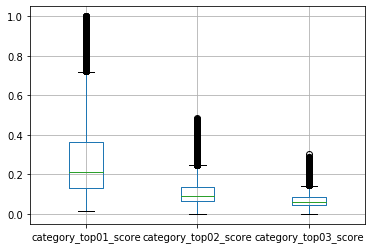

In [17]:
boxplot = filtered_vc_data.boxplot(column=['category_top01_score', 'category_top02_score', 'category_top03_score'])

In [18]:
if not os.path.exists(combined_place_categories_fp):
    PLACECNN_SCORE_THRESH = 0.2
    combined_place_category = {}
    image_ids = list(map(lambda path: get_image_id(path), filtered_vc_data['image_path'].values))
    for image_path in tqdm(image_path_white_list):
        date, image_name = image_path.split('/')[-2:]
        image_id = get_image_id(image_name)
        combined_place_category[image_id] = []
        try:
            row_index = image_ids.index(image_id)
            _, cat1, cat2, cat3, score1, score2, score3 = filtered_vc_data.iloc[row_index].values
            if score1 > PLACECNN_SCORE_THRESH:
                combined_place_category[image_id].append(' '.join(cat1.split('_')))
            if score2 > PLACECNN_SCORE_THRESH:
                combined_place_category[image_id].append(' '.join(cat2.split('_')))
            if score3 > PLACECNN_SCORE_THRESH:
                combined_place_category[image_id].append(' '.join(cat3.split('_')))
        except: print(image_path)
    
    with open(combined_place_categories_fp, 'w') as f:
        json.dump(combined_place_category, f, indent = 4)

# Generate Combined Date-time, GPS, and Activity

In [19]:
# Load metadata
lsc2020_metadata_fp = os.path.join(raw_data_path, 'lsc2020-metadata.csv')
time_alignment_fp = os.path.join(raw_data_path, 'LSC_time_alignments.csv')
combined_dt_gps_activity_fp = os.path.join(processed_data_path, 'combined_date_time_gps_activity.json')

lsc2020_metadata = pd.read_csv(lsc2020_metadata_fp, low_memory = False, keep_default_na = False, na_values = None)
time_alignments = pd.read_csv(time_alignment_fp, sep = ',')
filtered_metadata = lsc2020_metadata[['minute_id', 'local_time', 'semantic_name', 'lat', 'lon', 'activity_type']]
filtered_metadata.tail()

,minute_id,local_time,semantic_name,lat,lon,activity_type
164155,20180531_2355,2018-06-01_00:55,Home,53.389933,-6.1457153,NULL
164156,20180531_2356,2018-06-01_00:56,Home,53.389933,-6.1457153,NULL
164157,20180531_2357,2018-06-01_00:57,Home,53.389933,-6.1457153,NULL
164158,20180531_2358,2018-06-01_00:58,Home,53.389933,-6.1457153,NULL
164159,20180531_2359,2018-06-01_00:59,Home,53.389933,-6.1457153,NULL


## Re-align UTC time 

In [20]:
time_aligned_df = filtered_metadata.copy(deep = True)
for value in time_alignments.values:
    date, _, delta = value
    if delta == 0: continue 
    date = ''.join(date.split('-'))
    date_filtered_df = filtered_metadata[filtered_metadata['minute_id'].str.contains(date)]
    minute_ids = date_filtered_df['minute_id'].values
    local_time = date_filtered_df['local_time'].values
    
    # Align minute ids
    minute_ids = list(map(lambda dt: 
            (datetime.datetime.strptime(dt, '%Y%m%d_%H%M') + datetime.timedelta(minutes = delta))
            .strftime('%Y%m%d_%H%M'), minute_ids))
    # Align corresponding local time
    local_time = list(map(lambda dt: 
            (datetime.datetime.strptime(dt, '%Y-%m-%d_%H:%M') + datetime.timedelta(minutes = delta))
            .strftime('%Y-%m-%d_%H:%M'), local_time))

    # Update to data-frame
    indices = date_filtered_df.index
    time_aligned_df.loc[indices, 'minute_id'] = minute_ids
    time_aligned_df.loc[indices, 'local_time'] = local_time

In [21]:
if not os.path.exists(combined_dt_gps_activity_fp):
    combined_dt_gps_activity = {}
    for image_path in tqdm(image_path_white_list):
        date = image_path.split('/')[-2]
        year = get_year(date)
        minute_id = ''
        image_id = get_image_id(image_path)
        try:
            if year == 2015 or year == 2018:
                d, t = image_id.split('_')[-2:]
                minute_id = '_'.join([d, t[:4]])
            elif year == 2016:
                d, t = image_id.split('_')[:2]
                minute_id = '_'.join([d, t[:4]])
            row_index = list(time_aligned_df['minute_id'].values).index(minute_id)
            _minute_id, local_time, location_name, lat, lon, activity_type = time_aligned_df.iloc[row_index].values
            _date, _local_time = local_time.split('_')
            _local_time = datetime.time(int(_local_time[:2]), int(_local_time[3:]), 0)
            wod = get_week_day(_date)
            month = get_month(_date)
            year = get_year(_date)
            pod = part_of_day(_local_time)
            combined_dt_gps_activity[image_id] = {
                'minute_id': _minute_id,
                'date': _date,
                'local_time': local_time,
                'day_of_week': wod,
                'month': month,
                'year': year,
                'part_of_day': pod,
                'activity_type': '' if activity_type == 'NULL' else activity_type,
                'gps': [float(lat), float(lon)] if lat != 'NULL' and lon != 'NULL' else [],
                'location_name': location_name,
            }
        except Exception as e: 
            print(image_path)
    
    with open(combined_dt_gps_activity_fp, 'w') as f:
        json.dump(combined_dt_gps_activity, f, indent = 4)